In [1]:
pip install slycot

     |████████████████████████████████| 1.6MB 3.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for slycot: filename=slycot-0.4.0-cp37-cp37m-linux_x86_64.whl size=1417829 sha256=7a1a09a3b305a88b96ea6ba0c8c17f8c925a1c38e94aad021fc47f8553614654
  Stored in directory: /root/.cache/pip/wheels/a2/46/56/f82cbb2fd06556f4f3952a2eb2396e8fd29264fffecbaad3cf
Successfully built slycot


In [2]:
pip install control

     |████████████████████████████████| 348kB 3.7MB/s 
  Created wheel for control: filename=control-0.9.0-py2.py3-none-any.whl size=344920 sha256=1fd67662c606e12b51814e16ee74574dd424bb8e3f80c6b620e0e62082481380
  Stored in directory: /root/.cache/pip/wheels/35/be/ee/081b68ca3e4b2d253fba2f7f7e51960373903fb7b6d13c5532
Successfully built control


In [ ]:
q = 2   # Number of inputs
p = 2   # Number of outputs
n = 100 # State dimension
r = 10 # Reduced model order

testSys_mat = io.loadmat(os.path.join('..','DATA','testSys_ABCD.mat'))
A = testSys_mat['A']
B = testSys_mat['B']
C = testSys_mat['C']
D = testSys_mat['D']

sysFull = ss(A,B,C,D,1)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from control.matlab import *
import slycot
from scipy import signal,io
import os
from scipy.linalg import fractional_matrix_power

# Python control toolbox available at https://python-control.readthedocs.io/

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 18})


In [17]:
q = 1   # Number of inputs
p = 1   # Number of outputs
n = 100 # State dimension
r = 10 # Reduced model order

sysFull = rss(n,p,q)

In [18]:
yFull = np.zeros((r*5+2,p,q))
tspan = np.arange(0,(r*5+2),1)
m = len(tspan)

y , t = impulse(sysFull,T=tspan)


YY = np.transpose(y[:]) # reorder to size p x q x m

/usr/local/lib/python3.7/dist-packages/control/timeresp.py:1149: UserWarning: System has direct feedthrough: ``D != 0``. The infinite impulse at ``t=0`` does not appear in the output.
Results may be meaningless!
  warnings.warn("System has direct feedthrough: ``D != 0``. The "


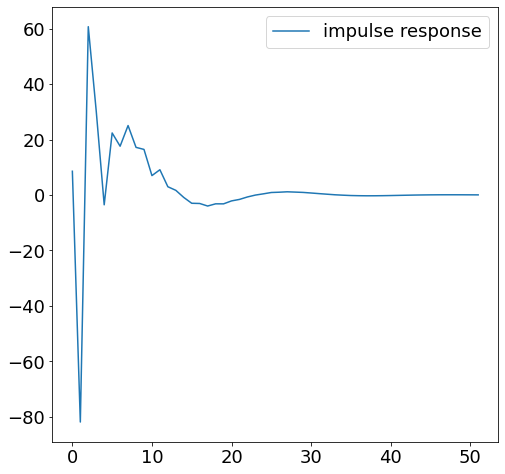

In [19]:
plt.plot(t,y,label='impulse response')
plt.legend()

In [20]:
## ERA and OKID Function Definitions

def ERA(YY,m,n,nin,nout,r):
    Dr = np.zeros((nout,nin))
    Y = np.zeros((nout,nin,YY.shape[0]-1))
    for i in range(nout):
        for j in range(nin):
            Dr[i,j] = YY[0]
            Y[i,j,:] = YY[1:]
    
     
    H = np.zeros((m,n))
    H1 = np.zeros((m,n))
    
    for i in range(m):
        for j in range(n):
            for Q in range(1):
                for P in range(1):
                    H[nout*i+Q,nin*j+P] = Y[Q,P,i+j]
                    H1[nout*i+Q,nin*j+P] = Y[Q,P,i+j+1]
                    
    U,S,VT = np.linalg.svd(H,full_matrices=0)
    V = VT.T
    Sigma = np.diag(S[:r])
    Ur = U[:,:r]
    Vr = V[:,:r]
    Ar = fractional_matrix_power(Sigma,-0.5) @ Ur.T @ H1 @ Vr @ fractional_matrix_power(Sigma,-0.5)
    Br = fractional_matrix_power(Sigma,0.5) @ Vr.T[:,:nin]
    Cr = Ur[:nout] @ fractional_matrix_power(Sigma,0.5)
    HSVs = S
    
    return Ar,Br,Cr,Dr,HSVs

def OKID(y,u,r):
    # inputs:  y (sampled output), u (sampled input), r (effective system order)
    # outputs: H (Markov parameters), M (Observer gain)
    
    P = y.shape[0] # number of outputs
    M = y.shape[1] # number of output samples
    Q = u.shape[0] # number of inputs
    lu = u.shape[1] # number of input samples
    
    assert M == lu
    
    L = r*5
    
    # Form data matrices y and V
    V = np.zeros((Q+(Q+P)*L,M))
    for i in range(M):
        V[:Q,i] = u[:Q,i]
        
    for i in range(1,L+1):
        for j in range(M-i):
            vtemp = np.concatenate((u[:,j],y[:,j]))
            V[Q+(i-1)*(Q+P):Q+i*(Q+P),i+j] = vtemp
    
    # Solve for observer Markov parameters Ybar
    Ybar = y @ np.linalg.pinv(V,rcond=1e-5)
    
    
    D = Ybar[:,:Q] # feed-through term (or D matrix) is the first term
    
    Y = np.zeros((P,Q,L))
    Ybar1 = np.zeros((P,Q,L))
    Ybar2 = np.zeros((P,Q,L))
    
    for i in range(L):
        Ybar1[:,:,i] = Ybar[:,Q+(Q+P)*i : Q+(Q+P)*i+Q]
        Ybar2[:,:,i] = Ybar[:,Q+(Q+P)*i+Q : Q+(Q+P)*(i+1)]
    
    Y[:,:,0] = Ybar1[:,:,0] + Ybar2[:,:,0] @ D
    for k in range(1,L):
        Y[:,:,k] = Ybar1[:,:,k] + Ybar2[:,:,k] @ D
        for i in range(k-1):
            Y[:,:,k] += Ybar2[:,:,i] @ Y[:,:,k-i-1]
            
    H = np.zeros((D.shape[0],D.shape[1],L+1))
    H[:,:,0] = D
    
    for k in range(1,L+1):
        H[:,:,k] = Y[:,:,k-1]
        
    return H

In [21]:
## Compute ERA from impulse response
mco = int(np.floor((yFull.shape[0]-1)/2)) # m_c = m_o = (m-1)/2
Ar,Br,Cr,Dr,HSVs = ERA(YY,mco,mco,q,p,r)
sysERA = ss(Ar,Br,Cr,Dr,1)

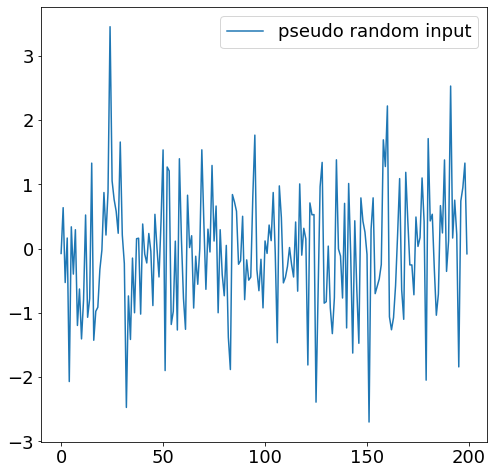

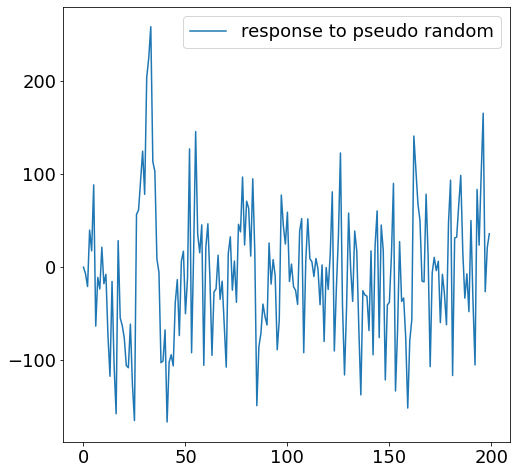

In [22]:
## Compute random input simulation for OKID
uRandom = np.random.randn(200,q) # Random forcing input
uRandom = uRandom.T
#yRandom = lsim(sysFull,uRandom,range(200))[0]#.T # Output
yRandom = np.array([lsim(sysFull,uRandom.T,range(200))[0]])

plt.plot(uRandom.T,label='pseudo random input')
plt.legend()
plt.show()
plt.plot(yRandom.T,label='response to pseudo random')
plt.legend()
plt.show()

In [23]:
## Compute OKID and then ERA
H = OKID(yRandom,uRandom,r)
mco = int(np.floor((H.shape[2]-1)/2)) # m_c = m_o
Ar,Br,Cr,Dr,HSVs = ERA(H[0,0,:],mco,mco,q,p,r)
sysERAOKID = ss(Ar,Br,Cr,Dr,1)

In [24]:
H[0,0,:]

array([-1.50689361e+01, -4.32328650e+01,  5.20649355e+01,  2.17990924e+01,
        2.17559961e+01,  3.46643874e+01,  2.62537654e+01,  1.93942314e+01,
        1.64851521e+01,  1.14646036e+01,  4.92695452e+00,  2.85249097e+00,
       -8.07187561e-01, -5.00354409e+00, -4.48792085e+00, -5.29325630e+00,
       -7.35857230e+00, -5.35856933e+00, -3.25028592e+00, -2.94242348e+00,
       -8.57812567e-01,  1.03798837e+00,  1.69541295e+00,  3.57587844e+00,
        4.40298269e+00,  2.88686960e+00,  2.84722017e+00,  3.75157346e+00,
        2.41627054e+00,  1.07086461e+00,  8.16097192e-01, -4.12327832e-01,
       -4.85408035e-01,  4.10763088e-01, -6.13668306e-01, -5.23643395e-01,
        1.06595692e+00,  8.31671433e-01, -3.45477342e-02,  6.29363639e-01,
        3.70893255e-01,  2.01072607e-01,  5.94131867e-01, -1.19201527e+00,
       -6.75470167e-01, -2.77299690e-01,  9.03733211e-01, -4.08058595e-01,
       -1.09006233e+00,  4.83776817e-01,  1.06484698e-01])

In [25]:
YY

array([ 8.55675514e+00, -8.18420341e+01,  6.06668142e+01,  3.02120796e+01,
       -3.53702242e+00,  2.23581925e+01,  1.75853218e+01,  2.50287868e+01,
        1.71652934e+01,  1.64297110e+01,  6.98865940e+00,  9.10115610e+00,
        2.97553092e+00,  1.67894129e+00, -8.86576704e-01, -2.98540735e+00,
       -3.06145835e+00, -3.97848055e+00, -3.18795030e+00, -3.19515325e+00,
       -2.13542820e+00, -1.59526074e+00, -7.11100461e-01, -3.39385499e-02,
        4.12838582e-01,  8.97982188e-01,  1.00164318e+00,  1.15049953e+00,
        1.04215414e+00,  9.25511929e-01,  7.16167229e-01,  4.93171881e-01,
        2.82387100e-01,  7.58220308e-02, -7.04851149e-02, -1.95552007e-01,
       -2.57114561e-01, -2.89953001e-01, -2.81253202e-01, -2.48665219e-01,
       -2.00052539e-01, -1.40604773e-01, -8.35724319e-02, -2.87526442e-02,
        1.44409077e-02,  4.78991180e-02,  6.83110129e-02,  7.78006269e-02,
        7.76239143e-02,  6.97020416e-02,  5.71496289e-02,  4.15604176e-02])

/usr/local/lib/python3.7/dist-packages/control/timeresp.py:1149: UserWarning: System has direct feedthrough: ``D != 0``. The infinite impulse at ``t=0`` does not appear in the output.
Results may be meaningless!
  warnings.warn("System has direct feedthrough: ``D != 0``. The "


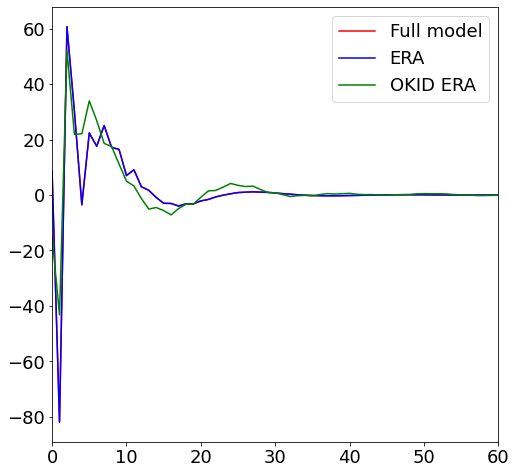

In [26]:
## Plot impulse responses for all methods

y1,t1 = impulse(sysFull,np.arange(100))
y2,t2 = impulse(sysERA,np.arange(100))
y3,t3 = impulse(sysERAOKID,np.arange(100))
   
plt.plot(t1,y1,label='Full model',color='r')
plt.plot(t2,y2,label='ERA',color='b')
plt.plot(t3,y3,label='OKID ERA',color='g')
plt.xlim([0,60])
plt.legend()
plt.show()